In [275]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn import metrics

from tqdm import tqdm_notebook

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import statsmodels.api as sm
from statsmodels.api import OLS

from pandas.plotting import scatter_matrix
from collections import Counter

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [276]:
ids = ['track_id', 'album_id']
predictors = ['track_number', 'track_count', 'duration', 'explicit', 
              'danceability', 'energy', 'loudness', 'speechiness', 
              'acousticness', 'instrumentalness', 'liveness', 
              'valence', 'tempo']
cols = ['track_number', 'track_count', 'duration', 'explicit', 'track_pop', 'album_pop', 
              'danceability', 'energy', 'loudness', 'speechiness', 
              'acousticness', 'instrumentalness', 'liveness', 
              'valence', 'tempo']
response = 'comparative_pop'

In [277]:
# Load data
train = pd.read_csv('data/training.csv')
test = pd.read_csv('data/testing.csv')

# Regularize
# Create a scaler
scaler = MinMaxScaler(feature_range=(-1,1))

# Fit scaler on data
no_id_train = train.drop(['track_id', 'album_id'], axis=1)
no_id_test = test.drop(['track_id', 'album_id'], axis=1)
scaler.fit(no_id_train)

# Apply transform
normalized_train = scaler.transform(no_id_train)
normalized_test = scaler.transform(no_id_test)

# Separate the features from the response
X_train = pd.DataFrame(normalized_train[:, :-1], columns = cols)[predictors]
y_train = pd.DataFrame(normalized_train[:, -1], columns = [response])

X_test = pd.DataFrame(normalized_test[:, :-1], columns = cols)[predictors]
y_test = pd.DataFrame(normalized_test[:, -1], columns = [response])

In [278]:
X_train.head()

,track_number,track_count,duration,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-0.908497,-0.965338,-0.869943,1.0,0.657895,0.058,0.544148,-0.852021,-0.929518,-0.896600,-0.6340,0.1240,-0.024629
1,-0.869281,-0.968804,-0.936310,-1.0,-0.016194,-0.006,0.670490,-0.916477,0.297189,-1.000000,-0.6700,0.3280,-0.286516
2,-0.856209,-0.961872,-0.892507,-1.0,-0.123482,0.004,0.715674,-0.942383,-0.991948,-0.999993,-0.8550,-0.9240,-0.423117
3,-1.000000,-0.989601,-0.482418,-1.0,-0.530364,-0.594,0.234586,-0.920207,0.935743,0.786000,-0.6260,-0.8546,0.286584
4,-0.921569,-0.961872,-0.924578,-1.0,0.099190,-0.684,0.540452,-0.932021,0.853414,0.752000,-0.8026,-0.8826,-0.321056


In [279]:
# simple OLS
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

lin_model = sm.OLS(y_train, X_train_const).fit()
print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:        comparative_pop   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     635.8
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:28:59   Log-Likelihood:                 15755.
No. Observations:              120793   AIC:                        -3.148e+04
Df Residuals:                  120779   BIC:                        -3.135e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1160      0.021  

//anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


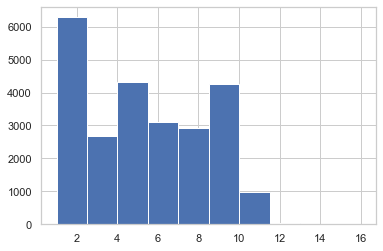

In [280]:
train['comparative_pop'].where(train['album_pop'] < train['track_pop']).hist()

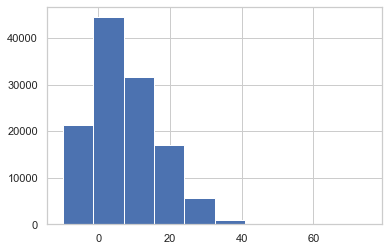

In [281]:
(train['album_pop'] - train['track_pop']).hist()

In [282]:
train_predict = lin_model.predict(X_train_const)
test_predict = lin_model.predict(X_test_const)

train_score = metrics.mean_squared_error(y_train, train_predict)
test_score = metrics.mean_squared_error(y_test, test_predict)

pd.DataFrame([["Linear Model", train_score, test_score]], columns = ['Model', 'Training MSE', 'Test MSE'])

,Model,Training MSE,Test MSE
0,Linear Model,0.045106,0.045137


In [283]:
# Add polynomial terms to dataset manually
X_train_poly = X_train.copy()
X_test_poly = X_test.copy()
for col in X_train.columns:
    X_train_poly[col + "^2"] = X_train[col]**2
    X_test_poly[col + "^2"] = X_test[col]**2
    
X_train_poly_const = sm.add_constant(X_train_poly)
X_test_poly_const = sm.add_constant(X_test_poly)

//anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [284]:
model_poly = sm.OLS(y_train, X_train_poly_const).fit()
print(model_poly_man.summary())

                            OLS Regression Results                            
Dep. Variable:        comparative_pop   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     411.1
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:29:23   Log-Likelihood:            -4.4959e+05
No. Observations:              120793   AIC:                         8.992e+05
Df Residuals:                  120767   BIC:                         8.995e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.0484      0

In [291]:
train_predict_poly = model_poly.predict(X_train_poly_const)
test_predict_poly = model_poly.predict(X_test_poly_const)

train_score_poly = metrics.mean_squared_error(y_train, train_predict_poly)
test_score_poly = metrics.mean_squared_error(y_test, test_predict_poly)

pd.DataFrame([["Linear w/ 2nd Degree Poly", train_score_poly, test_score_poly]], columns = ['Model', 'Training MSE', 'Test MSE'])

,Model,Training MSE,Test MSE
0,Linear w/ 2nd Degree Poly,0.044413,0.044654


In [271]:
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}
ridge_model = Ridge()
ridge_clf = GridSearchCV(ridge_model,params,cv=5,verbose = 1, scoring = 'neg_mean_squared_error')
ridge_clf.fit(X_train_poly_const,y_train)

ridge_clf.best_params_
#{'alpha': 4}

pd.DataFrame(ridge_clf.cv_results_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    2.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026766,0.002308,0.002198,0.000414,25,{'alpha': 25},-0.044732,-0.044545,-0.044320,-0.044410,-0.044321,-0.044466,0.000156,13
1,0.027861,0.002014,0.002441,0.000145,10,{'alpha': 10},-0.044709,-0.044520,-0.044310,-0.044376,-0.044314,-0.044446,0.000152,12
2,0.026436,0.001047,0.001977,0.000142,4,{'alpha': 4},-0.044700,-0.044509,-0.044313,-0.044361,-0.044318,-0.044440,0.000148,4
3,0.025844,0.000611,0.002006,0.000147,2,{'alpha': 2},-0.044697,-0.044505,-0.044317,-0.044355,-0.044321,-0.044439,0.000146,1
4,0.026707,0.001047,0.002085,0.000208,1,{'alpha': 1.0},-0.044696,-0.044504,-0.044322,-0.044352,-0.044323,-0.044439,0.000145,2
5,0.026055,0.000625,0.002207,0.000160,0.8,{'alpha': 0.8},-0.044696,-0.044504,-0.044324,-0.044352,-0.044323,-0.044440,0.000144,3
6,0.026231,0.001236,0.002063,0.000140,0.5,{'alpha': 0.5},-0.044696,-0.044503,-0.044328,-0.044351,-0.044324,-0.044440,0.000144,5
7,0.026064,0.000999,0.002144,0.000143,0.3,{'alpha': 0.3},-0.044695,-0.044503,-0.044332,-0.044350,-0.044324,-0.044441,0.000143,6
8,0.026852,0.001027,0.002207,0.000168,0.2,{'alpha': 0.2},-0.044695,-0.044503,-0.044334,-0.044350,-0.044325,-0.044441,0.000143,7
9,0.025780,0.000882,0.002026,0.000157,0.1,{'alpha': 0.1},-0.044695,-0.044503,-0.044337,-0.044350,-0.044325,-0.044442,0.000142,8


In [272]:
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}
lasso_model = Lasso()
lasso_clf = GridSearchCV(lasso_model,params,cv=5,verbose = 1, scoring = 'neg_mean_squared_error')
lasso_clf.fit(X_train_poly_const,y_train)

lasso_clf.best_params_
#{'alpha': 4}

pd.DataFrame(lasso_clf.cv_results_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    3.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.042623,0.002855,0.002442,0.000433,25,{'alpha': 25},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
1,0.042456,0.003248,0.002096,0.000189,10,{'alpha': 10},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
2,0.040768,0.001657,0.002201,0.000324,4,{'alpha': 4},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
3,0.043500,0.001753,0.002253,0.000227,2,{'alpha': 2},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
4,0.040701,0.001518,0.002137,0.000203,1,{'alpha': 1.0},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
5,0.041689,0.000974,0.002570,0.000604,0.8,{'alpha': 0.8},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
6,0.039721,0.000902,0.001922,0.000017,0.5,{'alpha': 0.5},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
7,0.039659,0.001005,0.002026,0.000125,0.3,{'alpha': 0.3},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
8,0.043616,0.001018,0.002469,0.000113,0.2,{'alpha': 0.2},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1
9,0.044009,0.000879,0.002540,0.000378,0.1,{'alpha': 0.1},-0.048357,-0.048165,-0.048063,-0.048232,-0.048151,-0.048194,0.000098,1


In [301]:
scores = -1 * cross_val_score(lasso_clf, X_test_poly_const, y_test, scoring = 'neg_mean_squared_error', cv=5)
scores.mean()

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.5s finished


0.0484128582972688

In [292]:
def fit_reg(Xtrain, ytrain, Xtest = None, ytest = None, model=LassoCV, cv_list = list(range(3,10)), alphas = [0.001, .01, .05, .1, .5, 1, 5, 10, 50, 100, 500], scoring = 'neg_mean_squared_error'):
    d = {'cv': [], 'mse': []}
    best_mse = 100
    best_cv = 0
    best_model = None
    if model == LassoCV:
        ytrain = np.ravel(ytrain)
    for cv in cv_list:
        temp_model = model(cv = cv)
        scores = -1 * cross_val_score(temp_model, Xtrain, ytrain, scoring = scoring, cv=cv)
        d['cv'].append(cv)
        d['mse'].append(scores.mean())
        if scores.mean() < best_mse:
            best_mse = scores.mean()
            best_cv = cv
            best_model = temp_model
    print("best_model:", best_model, "yielded MSE of:", best_mse)
    return [best_model, d]

In [297]:
lasso = fit_reg(X_train_poly_const, y_train)
pd.DataFrame(lasso[1])

best_model: LassoCV(alphas=None, copy_X=True, cv=6, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False) yielded MSE of: 0.04443519962908655


,cv,mse
0,3,0.044435
1,4,0.044439
2,5,0.044442
3,6,0.044435
4,7,0.044439
5,8,0.044439
6,9,0.044443


In [298]:
scores = -1 * cross_val_score(lasso[0], X_test_poly_const, y_test, scoring = 'neg_mean_squared_error', cv=6)
scores.mean()

//anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A colu

0.04519956280964759

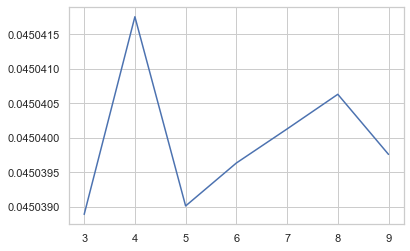

In [262]:
plt.plot(pd.DataFrame(lasso[1])['cv'], pd.DataFrame(lasso[1])['mse'])

In [295]:
ridge = fit_reg(X_train_poly_const, y_train, model = RidgeCV)
pd.DataFrame(ridge[1])

best_model: RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=6, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False) yielded MSE of: 0.04443220746050943


,cv,mse
0,3,0.044433
1,4,0.044436
2,5,0.044439
3,6,0.044432
4,7,0.044436
5,8,0.044436
6,9,0.044441


In [302]:
scores = -1 * cross_val_score(ridge[0], X_test_poly_const, y_test, scoring = 'neg_mean_squared_error', cv=6)
scores.mean()

0.04569179718349906

In [ ]:
# Add interaction terms to dataset
X_train_int = X_train.copy()
X_test_int = X_test.copy()
for first_col in X_train.columns:
    for second_col in X_train.columns.drop(first_col):
        X_train_int[first_col + "*" + second_col] = X_train[first_col]*X_train[second_col]
        X_test_int[first_col + "*" + second_col] = X_test[first_col]*X_test[second_col]

In [303]:
pd.DataFrame([["Linear", train_score, test_score],["Linear w/ 2nd Degree Poly", train_score_poly, test_score_poly],["Lasso w/ 2nd Degree Poly",0.044435,0.045200],["Ridge w/ 2nd Degree Poly",0.044432,0.045692]], columns = ['Model', 'Training MSE', 'Test MSE'])

,Model,Training MSE,Test MSE
0,Linear,0.045106,0.045137
1,Linear w/ 2nd Degree Poly,0.044413,0.044654
2,Lasso w/ 2nd Degree Poly,0.044435,0.045200
3,Ridge w/ 2nd Degree Poly,0.044432,0.045692
